In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

## Analyzing my favorite music

In [35]:
import spotipy

from dotenv import load_dotenv
from spotipy.oauth2 import SpotifyOAuth

load_dotenv()

scope = "user-library-read"

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

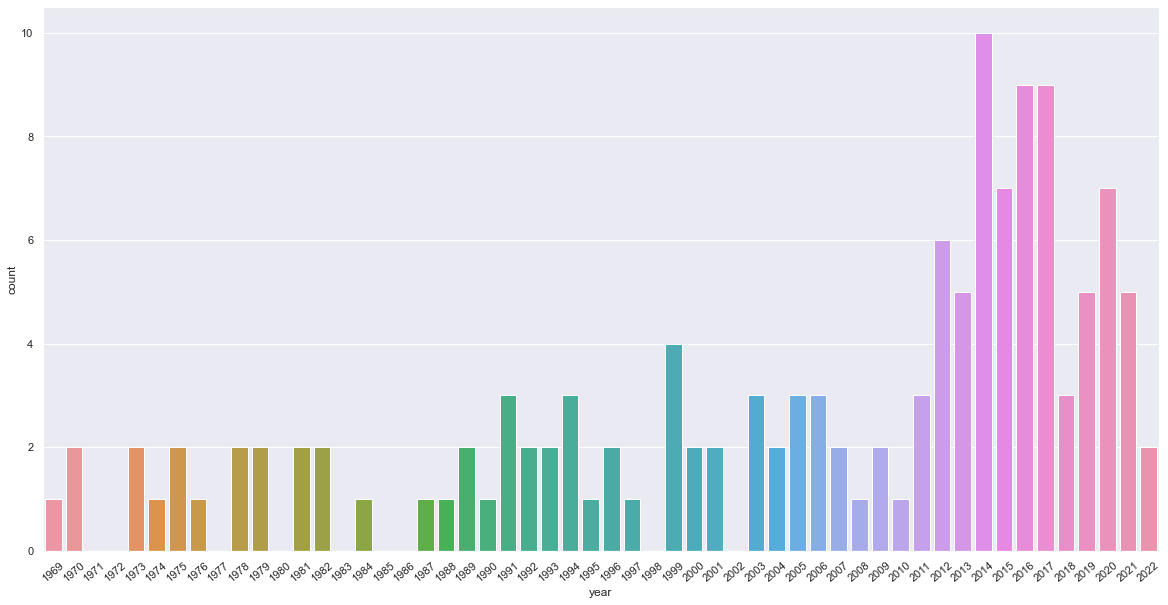

In [36]:
years = {year:0 for year in range(1969, 2023)}

for i in range(4):
    results = sp.current_user_saved_albums(limit=50, offset=50 * i)

    for item in results['items']:
        album = item["album"]
        release_date = int(album["release_date"][:4])

        if release_date not in years:
            years[release_date] = 1

        else:
            years[release_date] += 1

years = dict(sorted(years.items()))

df = pd.DataFrame(columns=["year", "count"])
df["year"] = years.keys()
df["count"] = years.values()

sb.set(rc={'figure.figsize':(20, 10)})

ax = sb.barplot(x="year", y="count", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40);

## Anime rating

In [39]:
import requests

from itertools import chain

query = """
query ($username: String) {
    MediaListCollection(
        userName: $username, 
        type: ANIME
    ) {
        lists {
            entries {
                score 

                media {
                    title {
                        english
                    }
                    
                    coverImage {
                        medium
                    }
                    
                    meanScore
                }
            }
        }
    }
}
"""

variables = {
    "username": "Skelozard",
}

url = 'https://graphql.anilist.co'

response = requests.post(url, json={'query': query, 'variables': variables})
json = response.json()
lists = json["data"]["MediaListCollection"]["lists"]
entries = list(chain.from_iterable([lists[i]["entries"] for i in range(len(lists))]))

df = pd.DataFrame(columns=["title", "mean_score", "user_score"])

for entry in entries:
    if entry["score"] == 0:
        continue

    media = entry["media"]
    row = pd.DataFrame({
        "title": [media["title"]["english"]],
        "image": [media["coverImage"]["medium"]],
        "mean_score": [media["meanScore"]],
        "user_score": [entry["score"]] ,
    })

    df = pd.concat([df, row], ignore_index=True, axis=0)

df = df.infer_objects()

df["score_difference"] = df["user_score"] - df["mean_score"]
df = df.sort_values("score_difference").reset_index(drop=True)

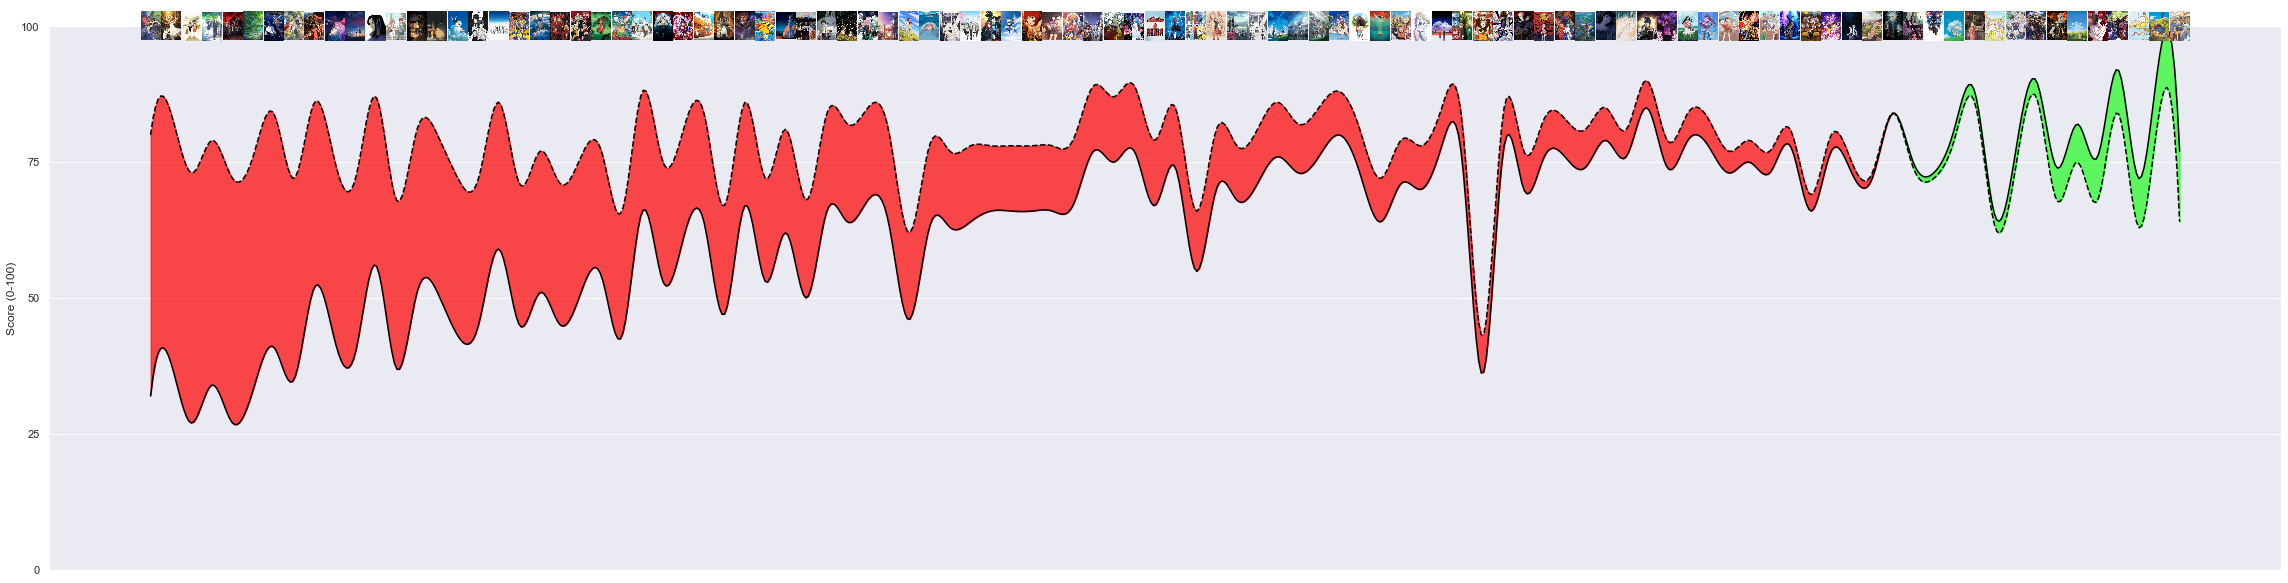

In [40]:
import cv2

from io import BytesIO
from PIL import Image
from scipy.interpolate import make_interp_spline
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)

plt.rcParams['figure.figsize'] = (40, 10)

fig, ax = plt.subplots()

x = df.index
y1 = df["user_score"]
y2 = df["mean_score"]

s1 = make_interp_spline(x, y1)
s2 = make_interp_spline(x, y2)

X = np.linspace(x.min(), x.max(), 800)

ax.plot(X, s1(X), color=(0, 0, 0))
ax.plot(X, s2(X), '--', color=(0, 0, 0))

ax.fill_between(X, s1(X), s2(X), where=(s1(X) - s2(X)) < 0, color=(1.0, 0, 0, 0.7))
ax.fill_between(X, s1(X), s2(X), where=(s1(X) - s2(X)) >= 0, color=(0, 1.0, 0, 0.6))

for i, url in enumerate(df["image"]):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    
    image_box = OffsetImage(image, zoom=0.2)
    annotation_box = AnnotationBbox(image_box, (i, 100), frameon=False)

    ax.add_artist(annotation_box)

plt.xticks([])
plt.ylim(0, 100)
plt.yticks(np.linspace(0, 100, 5))
plt.ylabel("Score (0-100)")
plt.savefig("anime.png", dpi=200, bbox_inches='tight')

plt.show()